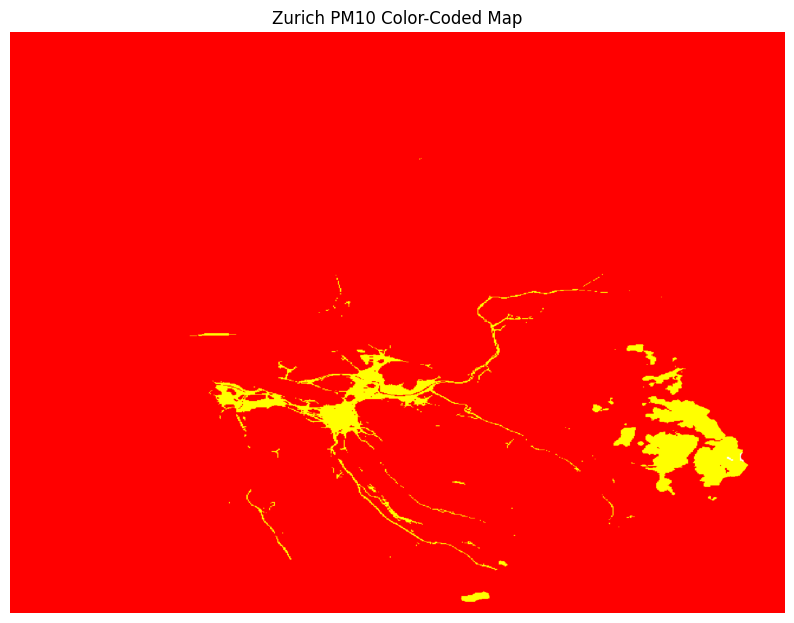

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- LOAD THE TIFF FILE ---
input_file = "../geoserver_data/data/zurich_pm10_raw.tif"

# Open the TIFF and convert to grayscale
image = Image.open(input_file).convert("L")
data = np.array(image)

# --- APPLY COLOR MAPPING ---
# Create RGB result array
result = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)

# Color rules: <100 white, 100–200 yellow, >200 red
result[data < 100] = [255, 255, 255]                 # White
result[(data >= 100) & (data <= 150)] = [255, 255, 0]  # Yellow
result[data > 150] = [255, 0, 0]                     # Red

# --- DISPLAY USING MATPLOTLIB ---
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title("Zurich PM10 Color-Coded Map")
plt.axis("off")
plt.show()


Min value: 0
Max value: 255
Mean value: 193.25


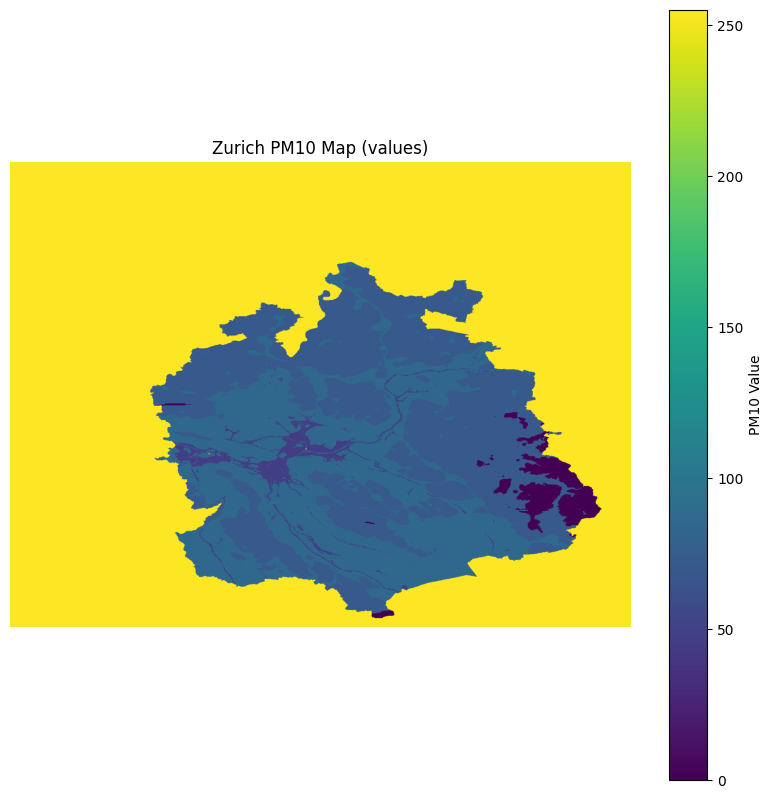

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# --- LOAD THE TIFF FILE ---
input_file = "../geoserver_data/data/zurich_pm10_raw.tif"

with rasterio.open(input_file) as src:
    data = src.read(1)  # Read the first band

# --- EXAMINE THE VALUES ---
print(f"Min value: {np.min(data)}")
print(f"Max value: {np.max(data)}")
print(f"Mean value: {np.mean(data):.2f}")

# --- DISPLAY USING MATPLOTLIB ---
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap="viridis")  # Use a continuous colormap
plt.colorbar(label="PM10 Value")
plt.title("Zurich PM10 Map (values)")
plt.axis("off")
plt.show()


Maximum pixel value: 351.0


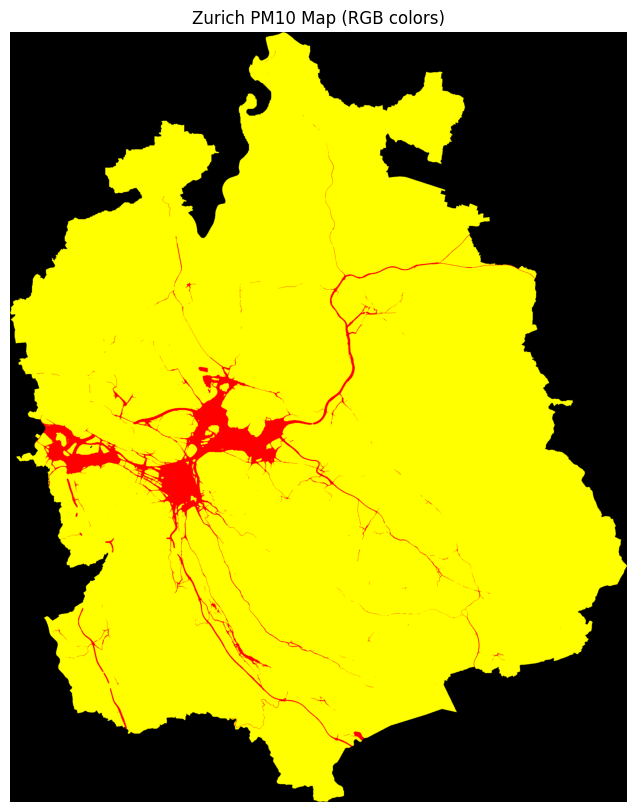

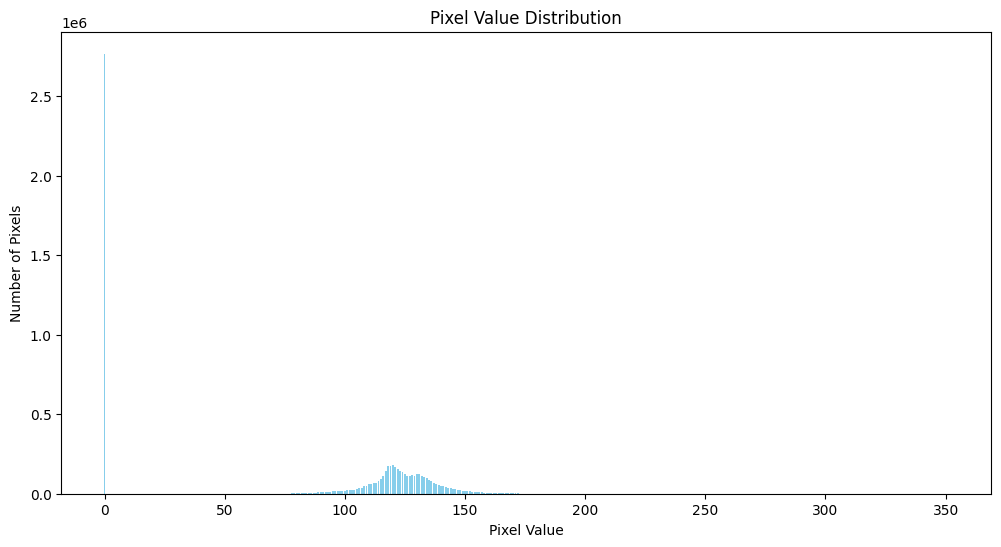

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# --- LOAD THE TIFF FILE ---
input_file = "../geoserver_data/data/test.tif"

with rasterio.open(input_file) as src:
    data = src.read(1).astype(float)  # convert to float to avoid overflow

# --- CREATE AN RGB IMAGE ---
# Initialize an empty array with 3 channels (height x width x 3)
result = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)

# Apply the color rules
result[data < 1] = [0,0,0]
result[(data >= 1) & (data <= 50)] = [0, 0, 255]               # Blue
result[(data >= 50) & (data <= 150)] = [255, 255, 0]  # Yellow
result[data > 150] = [255, 0, 0]                  # Red

max_value = data.max()
print(f"Maximum pixel value: {max_value}")
# --- DISPLAY USING MATPLOTLIB ---
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title("Zurich PM10 Map (RGB colors)")
plt.axis("off")
plt.show()

values, counts = np.unique(data, return_counts=True)

# --- PLOT THE PIXEL VALUE DISTRIBUTION ---
plt.figure(figsize=(12, 6))
plt.bar(values, counts, color='skyblue')
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Number of Pixels")
plt.show()

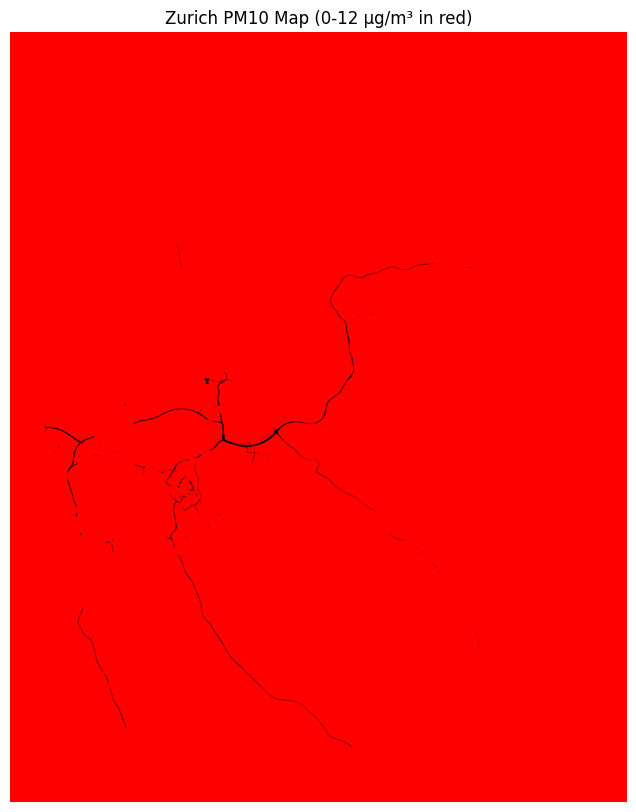

In [25]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the TIFF
with rasterio.open("../geoserver_data/data/test.tif") as src:
    data = src.read(1)  # read first band

# Create a mask for PM10 between 0 and 12
mask = (data >= 0) & (data <= 180)

# Prepare an RGB image: start with all black
result = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)

# Assign a color (e.g., red) to pixels in the range
result[mask] = [255, 0, 0]  # Red color, you can change to any RGB

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title("Zurich PM10 Map (0-12 µg/m³ in red)")
plt.axis("off")
plt.show()


Downloaded and saved to pm10_2020_raw.tif
Raster size: (2048, 2048)
Raster data type: uint8
Number of pixels between 0‑12 µg/m³: 135449


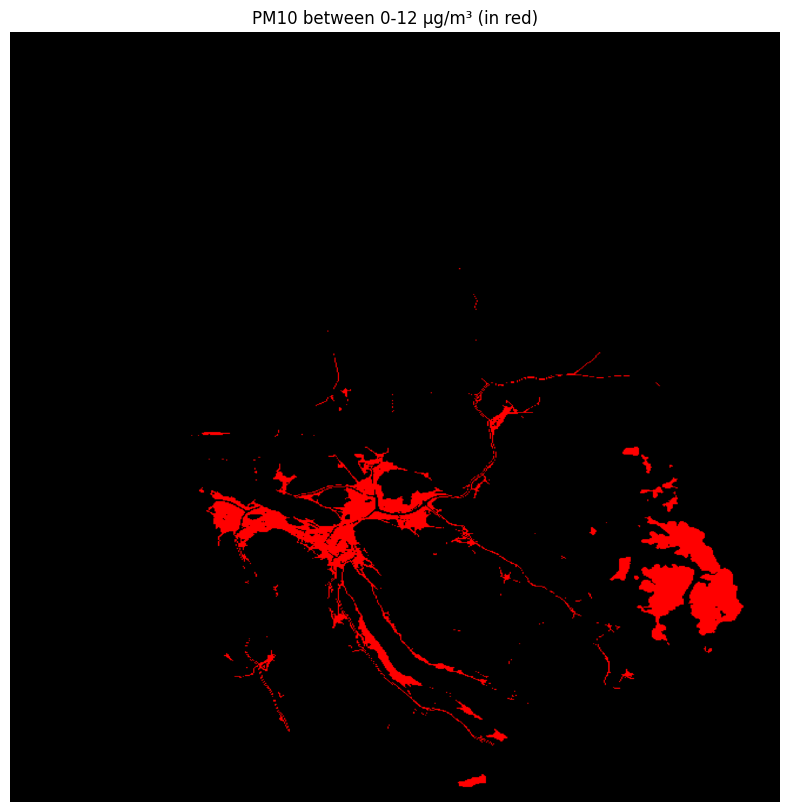

In [21]:
import requests
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the GetMap URL (raw TIFF)
url = (
    "https://wms.zh.ch/AwelLHPM10JahreZHWMS?"
    "SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&"
    "LAYERS=pm10-jahre-2020&STYLES=&"         # Empty STYLES to try get raw values
    "CRS=EPSG:2056&"
    "BBOX=2654500,1222400,2720000,1300000&"
    "WIDTH=2048&HEIGHT=2048&"                # higher resolution for better data
    "FORMAT=image/tiff"
)

# 2. Download the TIFF
print("Downloading TIFF from WMS …")
r = requests.get(url, stream=True)
r.raise_for_status()
fname = "pm10_2020_raw.tif"
with open(fname, "wb") as f:
    for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)
print(f"Downloaded and saved to {fname}")

# 3. Read the TIFF and filter the values
with rasterio.open(fname) as src:
    data = src.read(1)        # read first band
    print("Raster size:", data.shape)
    print("Raster data type:", data.dtype)
    mask = (data >= 0) & (data <= 50)    # pixel value filter
    filtered_values = data[mask]
    print("Number of pixels between 0‑12 µg/m³:", filtered_values.size)

# 4. (Optional) Visualise the filtered pixels
result = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)
result[mask] = [255, 0, 0]   # red for those pixels
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title("PM10 between 0‑12 µg/m³ (in red)")
plt.axis("off")
plt.show()
